# MPA Capacitance Calcs # 

This script calculates the depletion widths and dominant contributions to junction capacitance



In [1]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [2]:
import numpy as np
import lmfit as lmf
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
import os
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
%matplotlib inline

#to make fonts from plots look normal
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Calibri'
mpl.rcParams['mathtext.it'] = 'Calibri:italic'
mpl.rcParams['mathtext.bf'] = 'Calibri:bold'

font = {'family' : 'Calibri',
        'weight' : 'normal',
        'size'   : 36}
        #'sans-serif' : 'Arial Unicode MS'}
mpl.rc('font', **font)
plt.rc('font', size=36)          # controls default text sizes

#mpl.rcParams.update({'figure.autolayout': True})
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['xtick.minor.size'] = 4
mpl.rcParams['xtick.minor.width'] = 1.5
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['ytick.minor.size'] = 4
mpl.rcParams['ytick.minor.width'] = 1.5
mpl.rcParams['axes.linewidth'] = 1.5 #set the value globally
mpl.rcParams['lines.markersize'] = 16
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
#mpl.rcParams['xtick.top'] = False
#mpl.rcParams['ytick.right'] = False



In [3]:
# PbS capacitance at full depletion

# area in cm^2
area = 4e-2

eps0 = 8.854e-14

# MPA params (t = thickness in cm)
eps1 = 10
t1 = 1.90e-5

Cp = (eps1*eps0*area)/t1 

print(Cp)
print((Cp*1e9)/4e-2)

1.8639999999999998e-09
46.59999999999999


In [4]:
# ZnO capacitance

# solve for ZnO capaciance
Ctot = (30*1e-9*4e-2)

Cz_inv = 1/Ctot - 1/Cp

Cz = 1/Cz_inv
print(Cz)
print((Cz*1e9)/(4e-2))

#ZnO params 
eps3 = 3.7
# solve for ZnO depletion thickness 
t3 = (eps3*eps0*area)/Cz
print(t3)

3.368674698795183e-09
84.21686746987957
3.889933333333331e-06


In [5]:
# solve for depletion capacitance assuming C_{if} is PbS depletion in MPA
Cd = 135*1e-9*area
print(Cd)
d = (eps1*eps0*area)/Cd
print(d)


5.4e-09
6.558518518518518e-06


In [6]:
Cpd = (eps1*eps0*area)/d
print((Cpd*1e9)/4e-2)

135.0


In [7]:
# now try a different calculation. assume Cd is made up of both PbS and ZnO contributions. what do we get?

Cp2_inv = (1/Cd) - (1/Cz)

Cp2 = 1/Cp2_inv
print(Cp2)

-8.955160142348767e-09


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


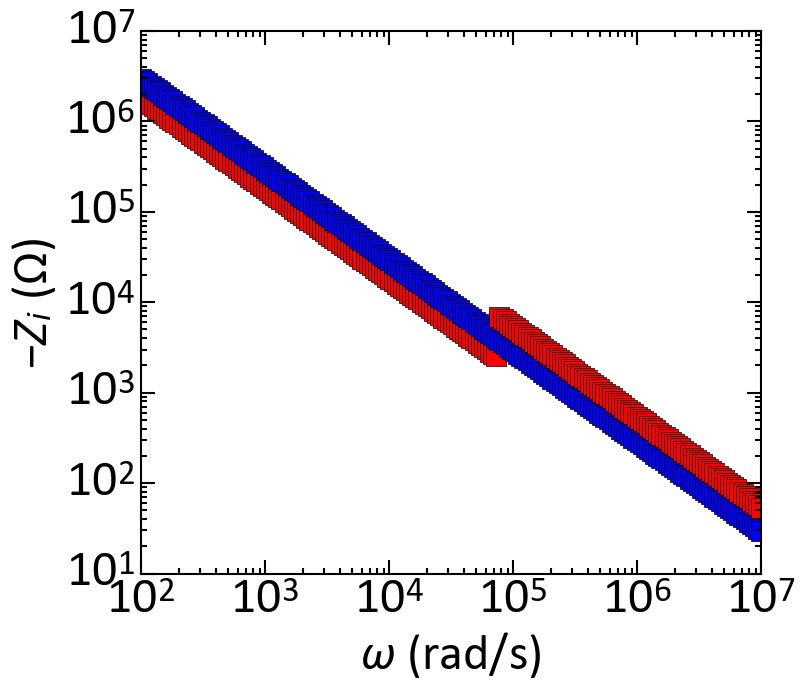

In [8]:
# run a very simple simulation of capacitance

figDir = r'C:\Users\Eric\Desktop\Lab_Work\admittance\ligand_and_interface\ligand_manuscript\currentVersion\MPA\capacitance\impedance_calc'


# frequency array
w = np.logspace(2,7,200)

# depletion capacitance of tbai before freeze-out in nanofarads/cm^2
# Cp1 = (4e-9*1e9)/4e-2
Cp1 = Cd
# print(Cp1)

# geometric capacitance of mpa after freeze-out in nanofarads/cm^2
# Cp2 = (Ct*1e9)/4e-2
Cp2 = Cp
# print(Cp2)

# depletion capacitance of ZnO
# Cz1 = (Cz*1e9)/4e-2
Cz1 = Cz

# print(Cz1)

# freeze-out frequency (approximate) in rad/s
omegaD = 7.4e4

Zi = np.zeros(len(w))
omegaD_idx = np.where(w >=omegaD)[0][0]

Z1 = np.zeros(len(w))
Z2 = np.zeros(len(w))

for freq in range(0,len(w)):
    Z2[freq] = np.imag(1/(1j*w[freq]*Cz1))
    
    if freq < omegaD_idx:
        Z1[freq] = np.imag(1/(1j*w[freq]*Cp1))
    elif freq >= omegaD_idx:
        Z1[freq] = np.imag(1/(1j*w[freq]*Cp2))

Zi = Z1+ Z2
        
fig,ax = plt.subplots(1,1, figsize = (8,7))
for freq in range(0,len(w)):
    ax.plot(w[freq],-Z1[freq],'s',markersize = 15,c = 'r')
    ax.plot(w[freq],-Z2[freq],'s',markersize = 15,c = 'b')
#     ax.plot(w[freq],-Zi[freq],'o',markersize = 10)
    
# ax.plot(w[omegaD_idx],-Zi[omegaD_idx],'o',markersize = 30)
ax.set_xlabel("$\\omega$ (rad/s)")
ax.set_ylabel("$-Z_{i}$ ($\\Omega$)")
ax.set_xscale('log')
ax.set_yscale('log')
# figName = '\\ZiCalc.png'
# plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')
    
# print(Zi)

In [9]:
# calculate debye length in ZnO given the detected carrier densities.

NdT = 2e23
kBj = 1.38e-23
q = 1.603e-19
eps0m = 8.85e-12


LT = np.sqrt(  (eps3*eps0m*kBj*300)/((q**2)*NdT) )
print(LT)

5.13598974321e-09


In [19]:
46+84

46/130

(84*46)/130

29.73/84

29.73/46

0.6463043478260869